In [1]:
import pandas as pd
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import re

In [2]:
sns.set_theme(context='notebook')
pio.renderers.default = "notebook"

In [3]:
connection = sqlite3.connect('./data/db/tourism.db')
cursor = connection.cursor()

In [4]:
query = '''
    SELECT
        a.country_code AS 'country_code',
        c.country AS 'country',
        c.region AS 'region',
        c.income_group AS 'income_group',
        AVG(p.population) AS 'avg_population',
        AVG(a.arrivals) AS 'avg_arrivals',
        AVG(d.departures) AS 'avg_departures',
        AVG(gdp.gdp) AS 'avg_gdp',
        AVG(gpc.gdp_per_capita) AS 'avg_gdp_per_capita',
        AVG(i.income) AS 'avg_income',
        AVG(r.receipts) AS 'avg_receipts'
    FROM arrivals a
    JOIN country c ON c.country_code = a.country_code
    JOIN departures d ON d.country_code = a.country_code AND d.'year' = a.'year'
    JOIN receipts r ON r.country_code = a.country_code AND r.'year' = a.'year'
    JOIN gdp ON gdp.country_code = a.country_code AND gdp.'year' = a.'year'
    JOIN gdp_per_capita gpc ON gpc.country_code = a.country_code AND gpc.'year' = a.'year'
    JOIN income i ON i.country_code = a.country_code AND i.'year' = a.'year'
    JOIN population p ON p.country_code = a.country_code AND p.'year' = a.'year'
    GROUP BY a.country_code;
    '''

df_country_avgs = pd.read_sql(query, connection)

df_country_avgs

country_code       country                      region  \
0            ABW         Aruba   Latin America & Caribbean   
1            AFG   Afghanistan                  South Asia   
2            AGO        Angola          Sub-Saharan Africa   
3            ALB       Albania       Europe & Central Asia   
4            AND       Andorra       Europe & Central Asia   
..           ...           ...                         ...   
212          XKX        Kosovo       Europe & Central Asia   
213          YEM   Yemen, Rep.  Middle East & North Africa   
214          ZAF  South Africa          Sub-Saharan Africa   
215          ZMB        Zambia          Sub-Saharan Africa   
216          ZWE      Zimbabwe          Sub-Saharan Africa   

            income_group  avg_population  avg_arrivals  avg_departures  \
0            High income    9.596996e+04  1.379000e+06             NaN   
1             Low income    2.671904e+07           NaN             NaN   
2    Lower middle income    2.221182e+07  2.493200e+05    3.000000e+03   
3    Upper middle income    2.982636e+06  2.094769e+06    3.424800e+06   
4            High income    7.190738e+04  9.276318e+06             NaN   
..                   ...             ...           ...             ...   
212  Upper middle income    1.800718e+06           NaN             NaN   
213           Low income    2.349298e+07  1.071833e+06             NaN   
214  Upper middle income    5.091926e+07  9.477946e+06             NaN   
215  Lower middle income    1.306436e+07  6.928462e+05             NaN   
216  Lower middle income    1.288383e+07  1.987654e+06    1.262227e+06   

          avg_gdp  avg_gdp_per_capita    avg_income  avg_receipts  
0    2.767456e+09        28821.629863  20182.848984  1.212908e+09  
1    1.554853e+10          507.160308    512.874531  9.992308e+07  
2    5.741432e+10         2486.071288   1454.693673  3.955000e+08  
3    8.944544e+09         3033.976099   2641.025497  1.178192e+09  
4    2.692026e+09        37228.516435           NaN  1.910000e+09  
..            ...                 ...           ...           ...  
212  6.059312e+09         3386.673055           NaN           NaN  
213  4.674431e+10         2017.477119    653.800479  8.191429e+08  
214  2.849038e+11         5543.953251   4582.622476  7.265077e+09  
215  1.446743e+10         1058.963008    735.822515           NaN  
216  1.760827e+10         1374.164801    706.349685  1.781154e+08  

[217 rows x 11 columns]

In [5]:
df_bachelors = pd.read_csv('./data/raw-data/bachelors/API_SE.TER.CUAT.BA.ZS_DS2_en_csv_v2_5996295.csv')
df_bachelors.dropna(axis=1, how='all', inplace=True)
df_bachelors.drop(['Country Name', 'Indicator Name', 'Indicator Code'], axis=1, inplace=True)
df_bachelors.rename(columns={'Country Code': 'country_code'}, inplace=True)
df_bachelors = df_bachelors.melt(id_vars='country_code', var_name='year', value_name='earned_bachelors')
df_bachelors.head()

country_code  year  earned_bachelors
0          ABW  1970               NaN
1          AFE  1970               NaN
2          AFG  1970               NaN
3          AFW  1970               NaN
4          AGO  1970               NaN

In [6]:
avg_country = df_bachelors.groupby('country_code').earned_bachelors.mean().reset_index()
avg_country

country_code  earned_bachelors
0            ABW         12.135297
1            AFE               NaN
2            AFG          3.526115
3            AFW               NaN
4            AGO          2.315715
..           ...               ...
261          XKX               NaN
262          YEM               NaN
263          ZAF          8.367857
264          ZMB          1.814720
265          ZWE          5.307000

[266 rows x 2 columns]

In [7]:
df_country_avgs_aggr = df_country_avgs.merge(avg_country, on='country_code')
df_country_avgs_aggr['pop_earned_bachelors'] = df_country_avgs_aggr['avg_population'] * df_country_avgs_aggr['earned_bachelors'] / 100
df_country_avgs_aggr

country_code       country                      region  \
0            ABW         Aruba   Latin America & Caribbean   
1            AFG   Afghanistan                  South Asia   
2            AGO        Angola          Sub-Saharan Africa   
3            ALB       Albania       Europe & Central Asia   
4            AND       Andorra       Europe & Central Asia   
..           ...           ...                         ...   
212          XKX        Kosovo       Europe & Central Asia   
213          YEM   Yemen, Rep.  Middle East & North Africa   
214          ZAF  South Africa          Sub-Saharan Africa   
215          ZMB        Zambia          Sub-Saharan Africa   
216          ZWE      Zimbabwe          Sub-Saharan Africa   

            income_group  avg_population  avg_arrivals  avg_departures  \
0            High income    9.596996e+04  1.379000e+06             NaN   
1             Low income    2.671904e+07           NaN             NaN   
2    Lower middle income    2.221182e+07  2.493200e+05    3.000000e+03   
3    Upper middle income    2.982636e+06  2.094769e+06    3.424800e+06   
4            High income    7.190738e+04  9.276318e+06             NaN   
..                   ...             ...           ...             ...   
212  Upper middle income    1.800718e+06           NaN             NaN   
213           Low income    2.349298e+07  1.071833e+06             NaN   
214  Upper middle income    5.091926e+07  9.477946e+06             NaN   
215  Lower middle income    1.306436e+07  6.928462e+05             NaN   
216  Lower middle income    1.288383e+07  1.987654e+06    1.262227e+06   

          avg_gdp  avg_gdp_per_capita    avg_income  avg_receipts  \
0    2.767456e+09        28821.629863  20182.848984  1.212908e+09   
1    1.554853e+10          507.160308    512.874531  9.992308e+07   
2    5.741432e+10         2486.071288   1454.693673  3.955000e+08   
3    8.944544e+09         3033.976099   2641.025497  1.178192e+09   
4    2.692026e+09        37228.516435           NaN  1.910000e+09   
..            ...                 ...           ...           ...   
212  6.059312e+09         3386.673055           NaN           NaN   
213  4.674431e+10         2017.477119    653.800479  8.191429e+08   
214  2.849038e+11         5543.953251   4582.622476  7.265077e+09   
215  1.446743e+10         1058.963008    735.822515           NaN   
216  1.760827e+10         1374.164801    706.349685  1.781154e+08   

     earned_bachelors  pop_earned_bachelors  
0           12.135297          1.164624e+04  
1            3.526115          9.421443e+05  
2            2.315715          5.143625e+05  
3           11.659310          3.477548e+05  
4           19.995056          1.437792e+04  
..                ...                   ...  
212               NaN                   NaN  
213               NaN                   NaN  
214          8.367857          4.260851e+06  
215          1.814720          2.370816e+05  
216          5.307000          6.837450e+05  

[217 rows x 13 columns]

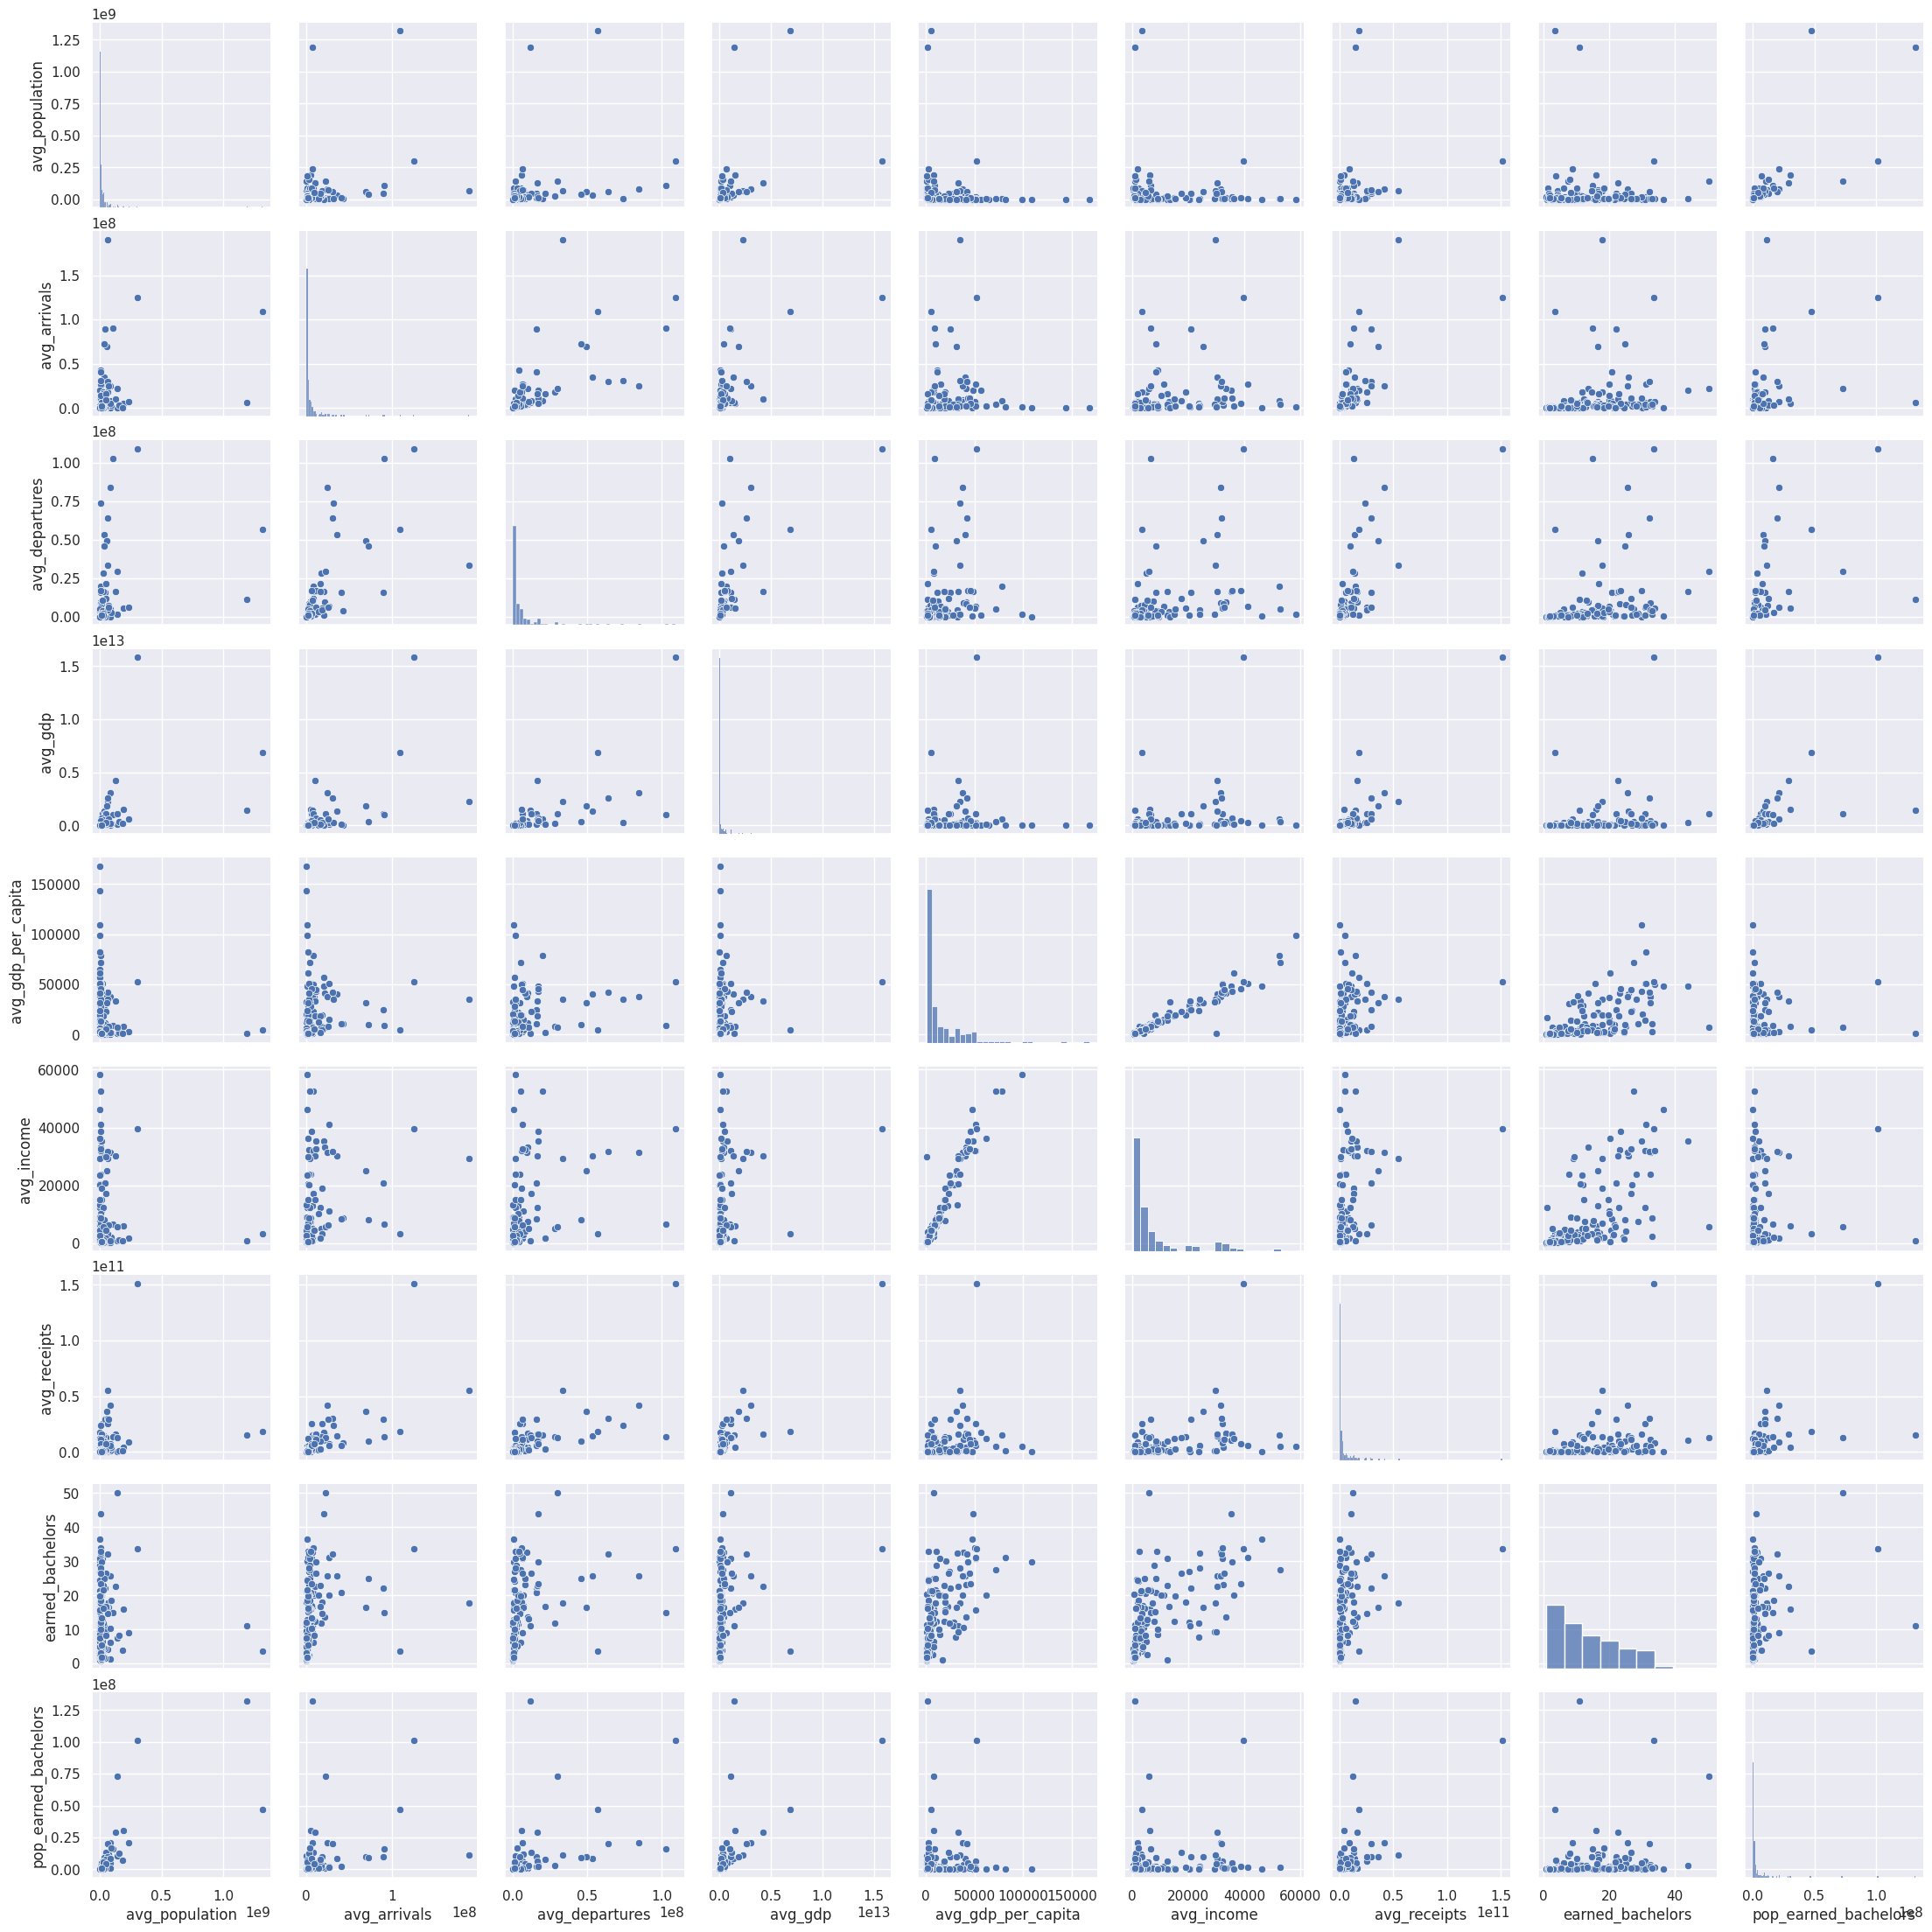

In [8]:
sns.pairplot(data=df_country_avgs_aggr)

In [9]:
def world_map_avgs(dataframe, dataframe_column, **kwargs):
    df = dataframe
    column_name = dataframe_column
    input_column = df[column_name]
    column_max = input_column.max()

    tick_text = [(column_max).round(-6) * n for n in np.arange(0, 1.25, 0.25)]
    print(tick_text)
    tick_vals = [np.log10(column_max) * n for n in np.arange(0, 1.25, 0.25)]
    print(tick_vals)

    #metric_name = str(metric_name).lower()
    if kwargs:
        try:
            input_zauto = bool(kwargs['z']['zauto'])
            input_zmin = int(kwargs['z']['zmin'])
            input_zmax = int(kwargs['z']['zmax'])
            fig = go.Figure(data=go.Choropleth(
                locations=df.country_code,
                z=input_column,
                zauto=input_zauto,
                zmin=input_zmin,
                zmax=input_zmax,
                text=df_country_avgs.country,
                colorscale = 'plasma',
                autocolorscale=False,
                reversescale=False,
                marker_line_color='darkgray',
                marker_line_width=0.5,
                colorbar_title = f'Average\nannual {column_name}')
                )
        except Exception as err:
            print(f'Error: {err}\nReverting to default parameters.')
            fig = go.Figure(data=go.Choropleth(
            locations=df_country_avgs.country_code,
            z=input_column,
            text=df_country_avgs.country,
            colorscale = 'plasma',
            autocolorscale=False,
            reversescale=False,
            marker_line_color='darkgray',
            marker_line_width=0.5,
            colorbar_title = f'Average\nannual {column_name}')
            )
    else:
        fig = go.Figure(data=go.Choropleth(
        locations=df.country_code,
        z=np.log10(input_column),
        text=df.country,
        colorscale='plasma',
        autocolorscale=False,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        colorbar={
            "tick0": 0,
            "ticktext": tick_text,
            "tickvals": tick_vals
        },
        customdata=input_column,
        hovertemplate='%{text}: %{customdata:4s}', 
        name=''
        )
        )

    fig.update_layout(
        title_text=column_name,
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='natural earth'
        )
    )

    fig.show()

In [10]:
for column in df_country_avgs_aggr.columns.tolist():
    if column not in ['country_code', 'country', 'region', 'income_group']:
        world_map_avgs(df_country_avgs_aggr, column)

[0.0, 329750000.0, 659500000.0, 989250000.0, 1319000000.0]
[0.0, 2.280056639800569, 4.560113279601138, 6.840169919401707, 9.120226559202276]


[0.0, 47500000.0, 95000000.0, 142500000.0, 190000000.0]
[0.0, 2.0697070456301154, 4.139414091260231, 6.209121136890346, 8.278828182520462]


[0.0, 27250000.0, 54500000.0, 81750000.0, 109000000.0]
[0.0, 2.0096806506645484, 4.019361301329097, 6.029041951993645, 8.038722602658193]


[0.0, 3959425500000.0, 7918851000000.0, 11878276500000.0, 15837702000000.0]
[0.0, 3.299923042967762, 6.599846085935524, 9.899769128903285, 13.199692171871048]


[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.3062039499496605, 2.612407899899321, 3.9186118498489817, 5.224815799798642]


[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.1912389790744156, 2.382477958148831, 3.5737169372232467, 4.764955916297662]


[0.0, 37783000000.0, 75566000000.0, 113349000000.0, 151132000000.0]
[0.0, 2.794839107401812, 5.589678214803624, 8.384517322205436, 11.179356429607248]


[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.4252608078517045, 0.850521615703409, 1.2757824235551136, 1.701043231406818]


[0.0, 33000000.0, 66000000.0, 99000000.0, 132000000.0]
[0.0, 2.030117593973367, 4.060235187946734, 6.090352781920101, 8.120470375893468]


In [11]:
rpgdp = 'receipts_percentage_of_gdp'
df_country_avgs[rpgdp] = df_country_avgs.avg_receipts / df_country_avgs.avg_gdp

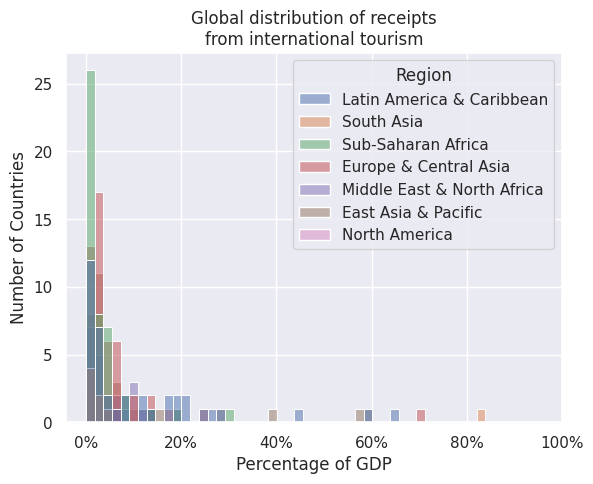

In [12]:
rpgdp_hist = sns.histplot(data=df_country_avgs, x=rpgdp, hue='region')
rpgdp_hist.set(title='Global distribution of receipts\nfrom international tourism', xlabel='Percentage of GDP', ylabel='Number of Countries')
rpgdp_hist.legend_.set_title('Region')
x_ticks = [0, 0.20, 0.40, 0.60, 0.80, 1.0]
rpgdp_hist.set_xticks(x_ticks)
rpgdp_hist.set_xticklabels(['{:.0%}'.format(x) for x in x_ticks])
plt.show()

It appears that tourism makes up less than 15% of the GDP of most countries, but there appear to be some noteable outliers. 

Because the histogram is so positively skewed, it's hard to gauge it accurately on appearance alone. Let's start by finding some measures of central tendency so that we can better classify each country by its economic dependence on tourism.

In [39]:
dependence_centers = {}
dc = dependence_centers

dc['mean'] = df_country_avgs[rpgdp].mean()
dc['median'] = df_country_avgs[rpgdp].median()
dc['std'] = df_country_avgs[rpgdp].std()
dc['quarts'] = df_country_avgs[rpgdp].quantile([0.25, 0.75], interpolation='nearest')

print(f'Mean: {dc['mean']:.2%}')
print(f'Median: {dc['median']:.2%}')
print(f'Standard Deviation: {dc['std']:.2%}')
print(f'Q1: {dc['quarts'][0.25]:.2%}\nQ3: {dc['quarts'][0.75]:.2%}')

Mean: 7.18%
Median: 2.81%
Standard Deviation: 12.59%
Q1: 1.34%
Q3: 6.70%


Now that we have those out of the way, we can begin classifying the countries into the degree of their economic dependency on tourism using the following four categories:

-Mainly Dependent

-Moderately Dependent

-Partly Dependent

-Independent

 Let's classify the countries that are mainly to wholly economically dependent on tourism. We'll classify anything more than one standard deviation away from the median as "Mainly Dependent."

In [40]:
one_sigma = dc['median'] + dc['std']
mainly_dependent_countries = df_country_avgs[['country',rpgdp]].loc[df_country_avgs[rpgdp] >= one_sigma].sort_values(by=rpgdp, ascending=False)
mainly_dependent_countries.reset_index(drop=True, inplace=True)
mainly_dependent_countries.style.format({rpgdp: '{:.2%}'})

It appears that all of the countries that have a higher dependance on tourism are small.  Almost all of them are also island nations, with the only exceptions being Andorra, Macau, Montenegro and Croatia. Let's confirm that by grouping it by region.

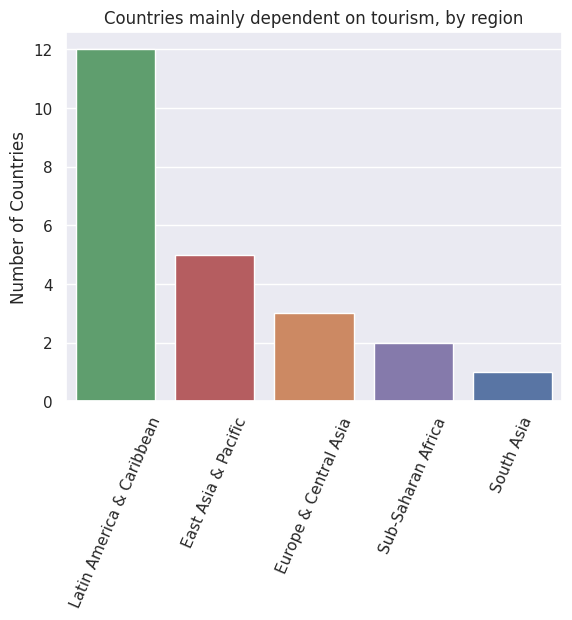

In [43]:
mainly_dependent_regions = mainly_dependent_countries.merge(right=df_country_avgs[['country', 'region']], on='country').reset_index(drop=True)

regional_mainly = sns.countplot(data=mainly_dependent_regions, x='region', hue='region', order=mainly_dependent_regions.value_counts('region').index)

for tick in regional_mainly.get_xticklabels():
    tick.set_rotation(66.67)

regional_mainly = regional_mainly.set(title='Countries mainly dependent on tourism, by region', xlabel='', ylabel='Number of Countries')
plt.show()

Let's next take a look at the other countries on a map. Because of how heavily skewed the data is, we can see a greater difference in the colors of countries that are less dependant on tourism by setting the color scale to the upper bound of one standard deviation, 15.4%.

In [44]:
fig = go.Figure(data=go.Choropleth(
        locations=df_country_avgs.country_code,
        z=df_country_avgs[rpgdp],
        zauto=False,
        zmax=0.154,
        text=df_country_avgs.country,
        colorscale=[
            [0.0, 'rgb(0,24,128)'],
            [0.1774, 'rgb(225,230,230)'],
            [0.1874, 'rgb(230,230,220)'],
            [0.3643, 'rgb(215,80,60)'],
            [1.0, 'rgb(128,24,0)']
        ],
        autocolorscale=False,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        colorbar=dict(
            tickformat='.0%'
        ),
        )
        )

fig.show()

It appears that, on the whole, most countries have a very low dependance on tourism; however, there are still some countries that are visibly more dependant on it than others.

Let's see which ones those may be, starting with those that are moderatley dependent on tourism, which we will define as the lower bound of the upper quartile to the upper bound of one standard deviation, which would be 6.70% to 15.4%.

In [45]:
moderately_dependent_countries = df_country_avgs[['country',rpgdp]].loc[(df_country_avgs[rpgdp] >= dc['quarts'][0.75]) & (df_country_avgs[rpgdp] < one_sigma)].sort_values(by=rpgdp, ascending=False)
moderately_dependent_countries.reset_index(drop=True, inplace=True)
moderately_dependent_countries.style.format({rpgdp: '{:.2%}'})

There are roughly the same amount, but these countries are much more diverse. As a result, the list alone is a bit more difficult to conceptualize at a glance, so let's split this up by region.

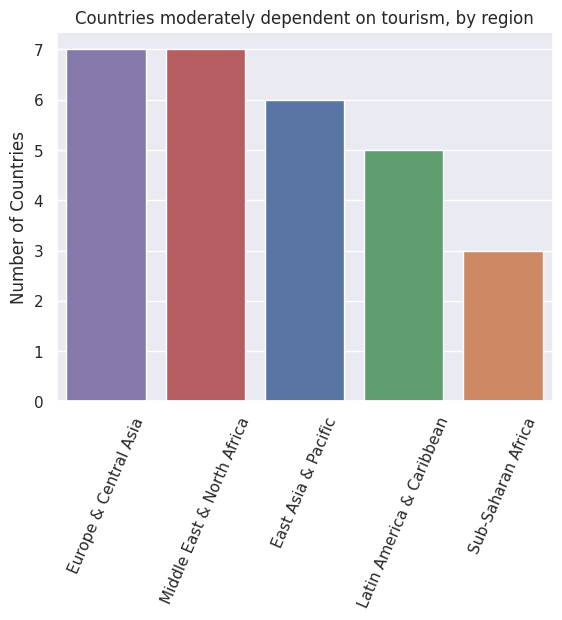

In [46]:
moderately_dependent_regions = moderately_dependent_countries.merge(right=df_country_avgs[['country', 'region']], on='country').reset_index(drop=True)

regional_moderately = sns.countplot(data=moderately_dependent_regions, x='region', hue='region', order=moderately_dependent_regions.value_counts('region').index)

for tick in regional_moderately.get_xticklabels():
    tick.set_rotation(66.67)

regional_moderately = regional_moderately.set(title='Countries moderately dependent on tourism, by region', xlabel='', ylabel='Number of Countries')
plt.show()

It looks like most of the countries with economies that are partly dependant on tourism are predominantly located in the Europe & Central Asia, the Middle East & North Africa, and East Asia & Pacific regions.

Let's continue our classification with countries that are partly dependent on tourism.

In [48]:
partly_dependent_countries = df_country_avgs[['country', rpgdp]].loc[(df_country_avgs[rpgdp] > dc['median']) & (df_country_avgs[rpgdp] < dc['quarts'][0.75])].sort_values(by=rpgdp, ascending=False)
partly_dependent_countries.reset_index(drop=True, inplace=True)
partly_dependent_countries.style.format({rpgdp: '{:.2%}'})

There are considerably more countries in this category--almost as much as the other two combined! This really needs to be broken up regionally to see any kind of trend.

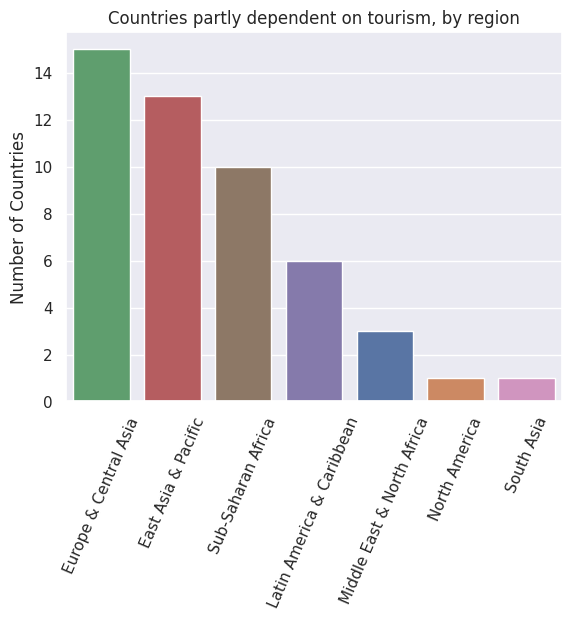

In [49]:
partly_dependent_regions = partly_dependent_countries.merge(right=df_country_avgs[['country', 'region']], on='country').reset_index(drop=True)

regional_partly = sns.countplot(data=partly_dependent_regions, x='region', hue='region', order=partly_dependent_regions.value_counts('region').index)

for tick in regional_partly.get_xticklabels():
    tick.set_rotation(66.67)

regional_partly = regional_partly.set(title='Countries partly dependent on tourism, by region', xlabel='', ylabel='Number of Countries')
plt.show()

This is definitely the most diverse group so far. The dominant regions are Europe & Central Asia, East Asia & Pacific, and Sub-Saharan Africa.

Finally, let's see which countries we would classify as economically "independent". 

In [55]:
independent_countries = df_country_avgs[['country', rpgdp]].loc[df_country_avgs[rpgdp] <= dc['median']].sort_values(rpgdp, ascending=False)
independent_countries

country  receipts_percentage_of_gdp
113            Sri Lanka                    0.028141
193          Timor-Leste                    0.027098
83              Honduras                    0.027092
195  Trinidad and Tobago                    0.026859
14               Belgium                    0.026614
..                   ...                         ...
72                Guinea                    0.001033
13               Burundi                    0.000705
75     Equatorial Guinea                    0.000632
39      Congo, Dem. Rep.                    0.000497
155     Papua New Guinea                    0.000335

[101 rows x 2 columns]

This list, as the math would suggest, contains about half of the world's countries. 

Let's see how it breaks down regionally.

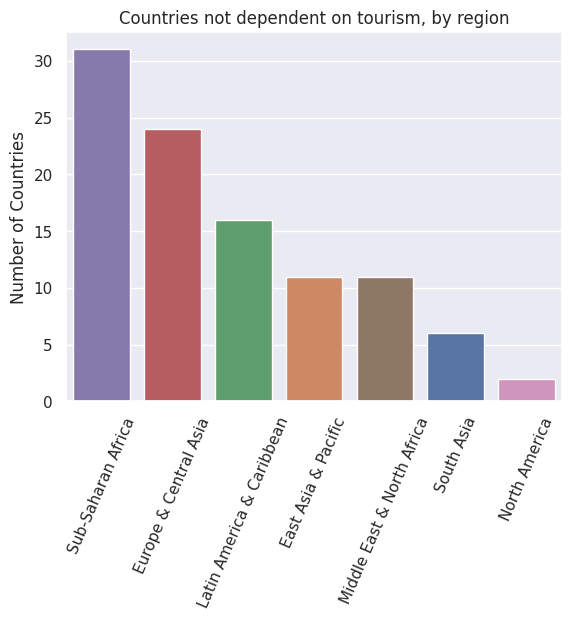

In [56]:
independent_regions = independent_countries.merge(right=df_country_avgs[['country', 'region']], on='country').reset_index(drop=True)

regional_independent = sns.countplot(data=independent_regions, x='region', hue='region', order=independent_regions.value_counts('region').index)

for tick in regional_independent.get_xticklabels():
    tick.set_rotation(66.67)

regional_independent = regional_independent.set(title='Countries not dependent on tourism, by region', xlabel='', ylabel='Number of Countries')
plt.show()

This is the most diverse set of regions, with every possible region having countries that are not economically dependent on tourism.